**Semantic Segmentation on Cambridge-driving Labeled Video Database**

Aim of the project is know which pixel belongs to which entity(like buildings, trees, roads, sidewalks) in the dataset via semantic segmentation. The Cambridge-driving Labeled Video Database is used on the project.

**IMPORT**

In [ ]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
from keras import backend as K
from tensorflow.keras import losses, optimizers, metrics, callbacks


**LOADING DATA**

The Cambridge-driving Labeled Video Database (CamVid) is the first collection of videos with object class semantic labels, complete with metadata. The database provides ground truth labels that associate each pixel with one of 32 semantic classes.

In [ ]:
#download the data set from github
!git clone https://github.com/GeorgeSeif/Semantic-Segmentation-Suite.git

fatal: destination path 'Semantic-Segmentation-Suite' already exists and is not an empty directory.


In [ ]:
'''
Read and output the entire contents of the input filename by io.read_file
Decode a JPEG-encoded image to a uint8 tensor by image.decode_jpeg
'''
def load_images(img_path, label_path, split='train'):
    img =  tf.io.read_file('Semantic-Segmentation-Suite/CamVid' + '/' + split + '/'+ img_path )
    img = tf.image.decode_jpeg(img, channels=3) 
    img_label =  tf.io.read_file('Semantic-Segmentation-Suite/CamVid' + '/' + split +'_labels'+ '/' + label_path )
    img_label = tf.image.decode_jpeg(img_label, channels=3) 
    img = tf.cast(img, tf.float32) / 255.0 # normalization
    return (img, img_label)



In [ ]:
'''
return a list containing the names of the entries in the directory given by path. (The list is in arbitrary order)
'''
train_paths = os.listdir('/content/Semantic-Segmentation-Suite/CamVid/train')
train_label_paths = [path[:-4]+'_L'+'.png' for path in train_paths ] # names are ending with L in the label folders

val_paths = os.listdir('/content/Semantic-Segmentation-Suite/CamVid/val')
val_label_paths = [path[:-4]+'_L'+'.png' for path in val_paths ]

test_paths = os.listdir('/content/Semantic-Segmentation-Suite/CamVid/test')
test_paths = sorted(test_paths)
test_label_paths = [path[:-4]+'_L'+'.png' for path in test_paths ]

Semantic segmentation is different from object detection as it does not predict any bounding boxes around the objects. We do not distinguish between different instances of the same object. For example, as seen in the following label example there could be multiple tree in the scene and all of them would have the same label.

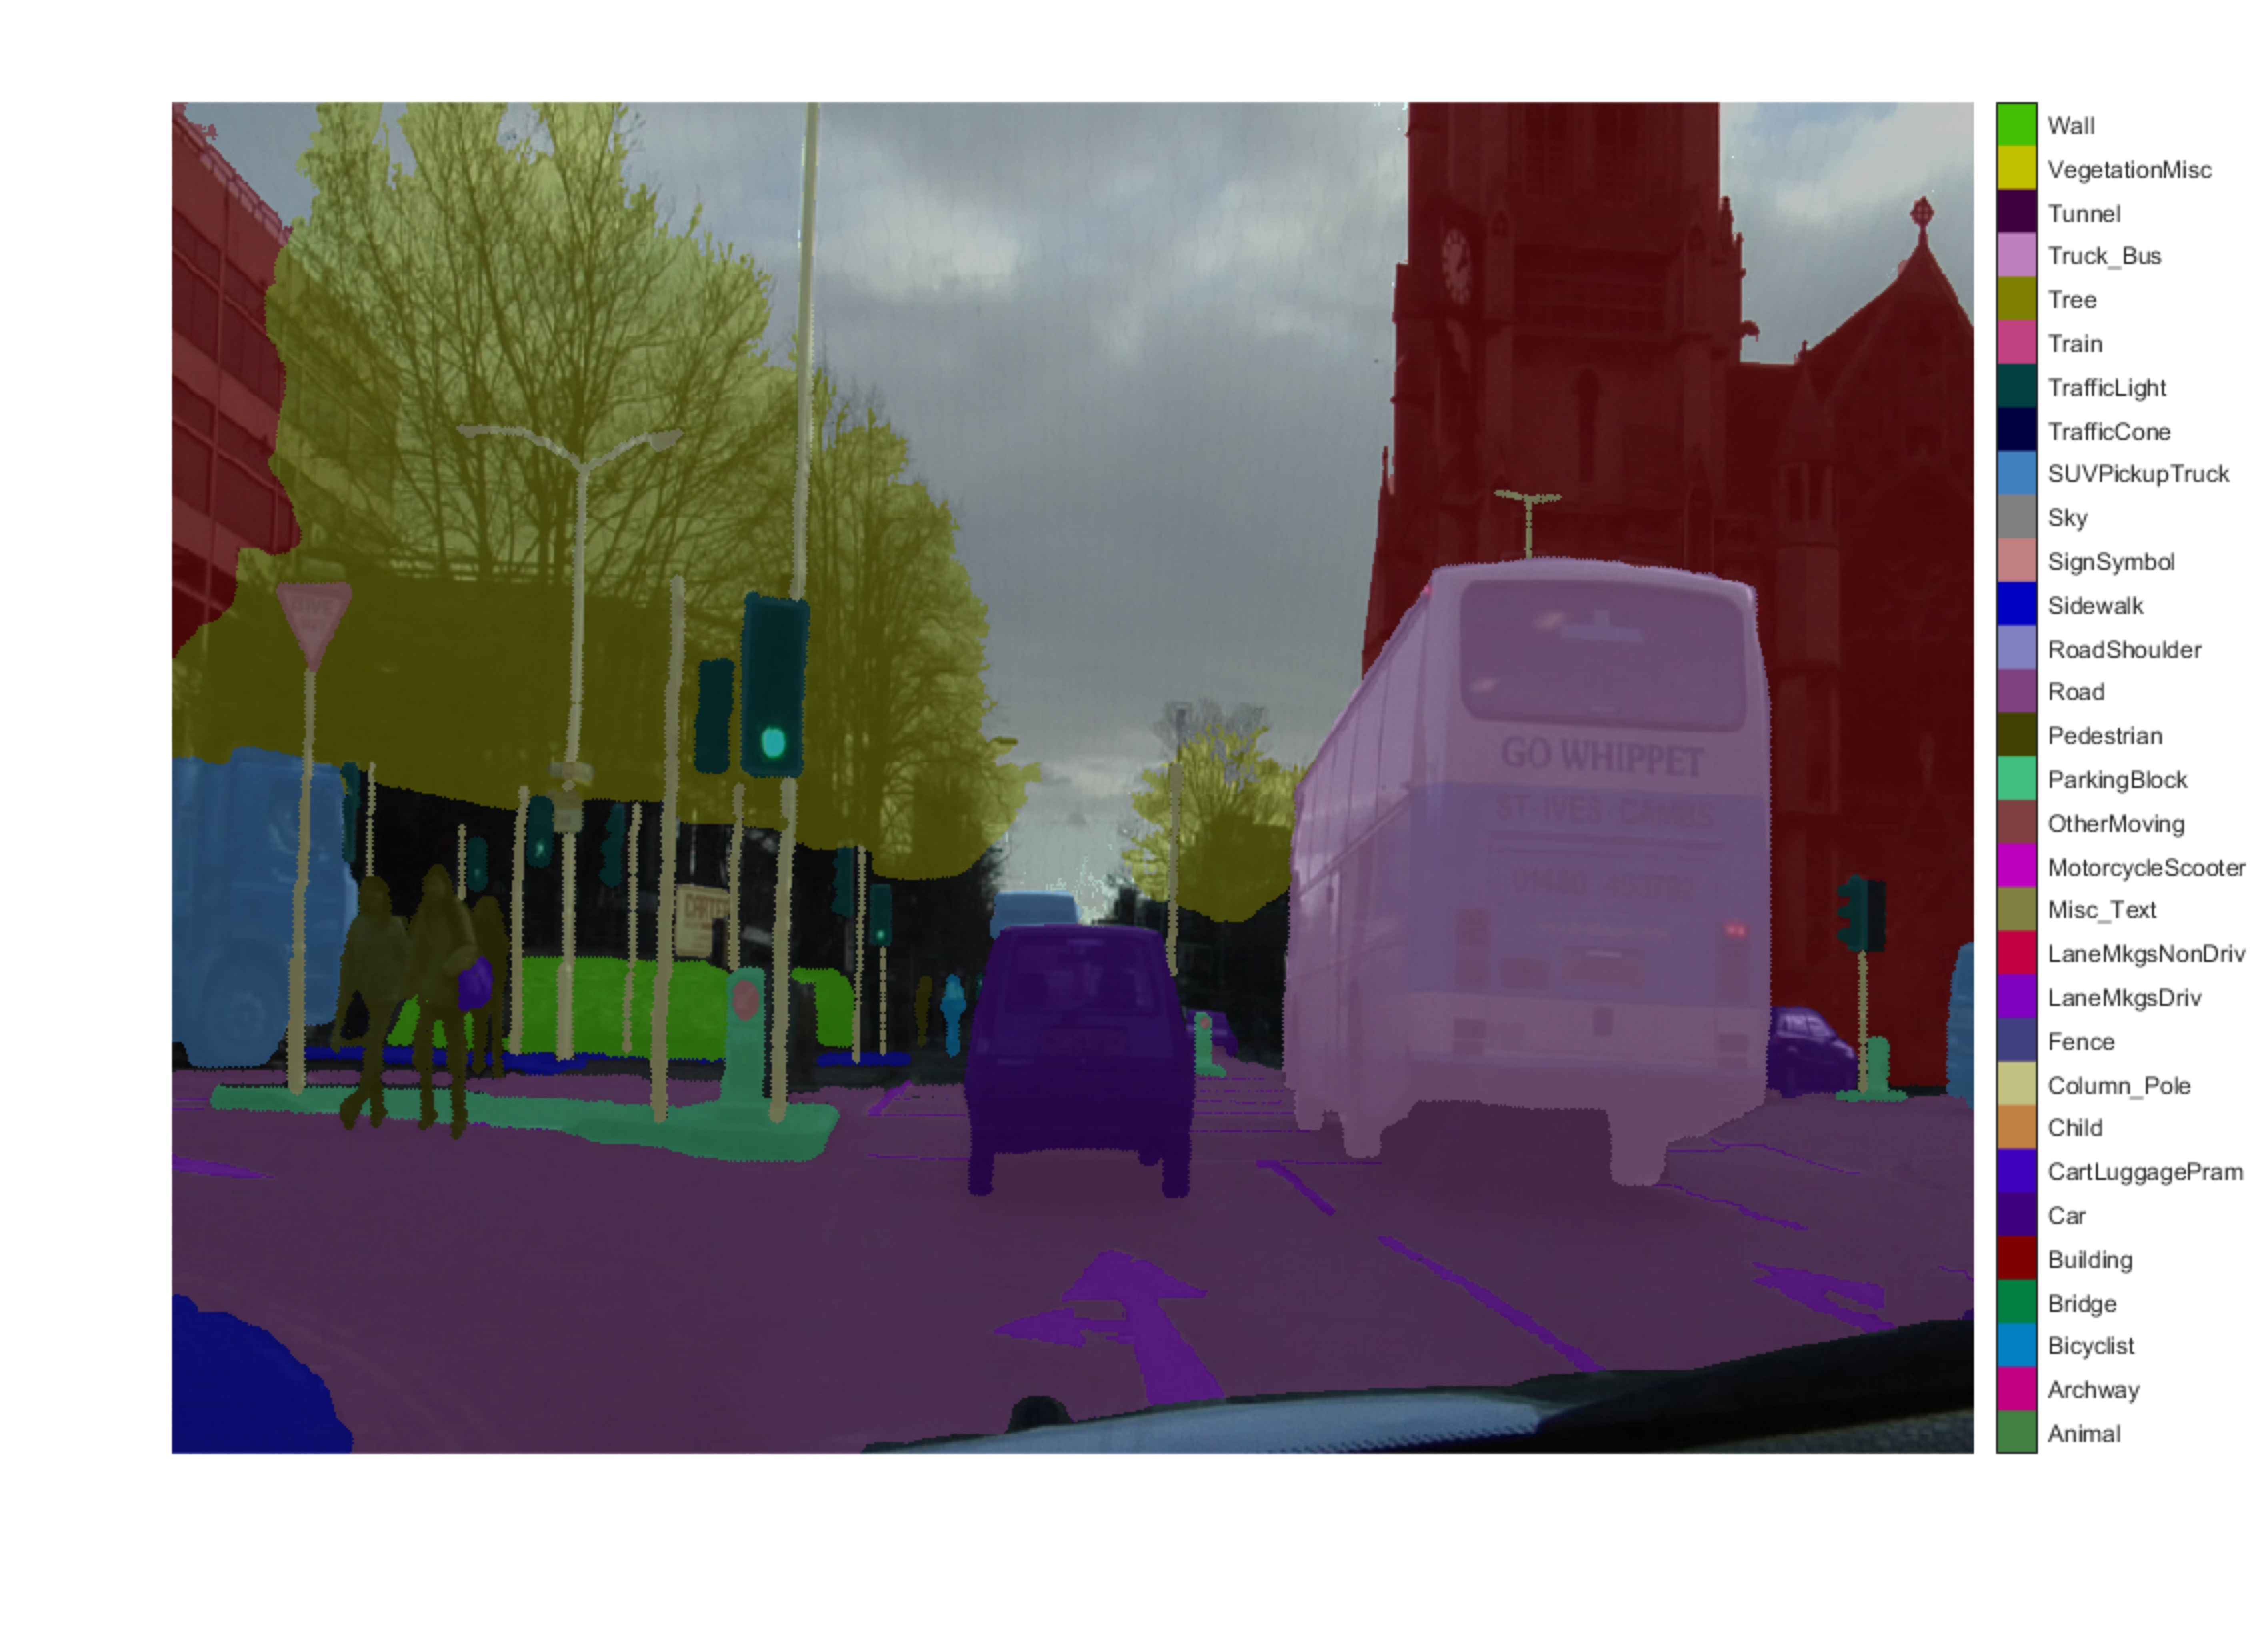

**SEMANTIC CLASSES**

In [ ]:
'''
class_dict.csv provides names of semantic classes and their  RGB colors
'''
classes = pd.read_csv('/content/Semantic-Segmentation-Suite/CamVid/class_dict.csv', index_col =0)

In [ ]:
'''' shape of semantic classes'''
classes.shape 

(32, 3)

In [ ]:
classes.head()

,r,g,b
name,,,
Animal,64,128,64
Archway,192,0,128
Bicyclist,0,128,192
Bridge,0,128,64
Building,128,0,0


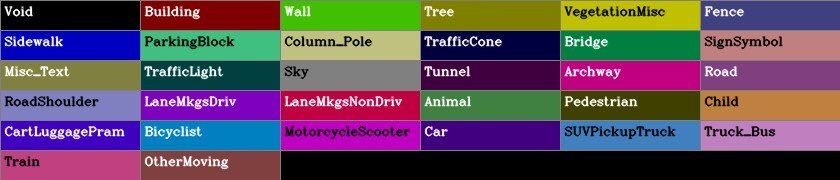

In [ ]:
'''
create a dictionary that maps class index to respective RGB color
'''
class_rgb = {idx:list(classes.loc[cl, :]) for  idx, cl in enumerate(classes.index)}

In [ ]:
'''shown the dictionary'''
list(class_rgb.items())[:5]

[(0, [64, 128, 64]),
 (1, [192, 0, 128]),
 (2, [0, 128, 192]),
 (3, [0, 128, 64]),
 (4, [128, 0, 0])]

The goal is as shown in the representative example below to take an image of size W x H x 3 and generate a W x H matrix containing the predicted class ID’s corresponding to all the pixels.

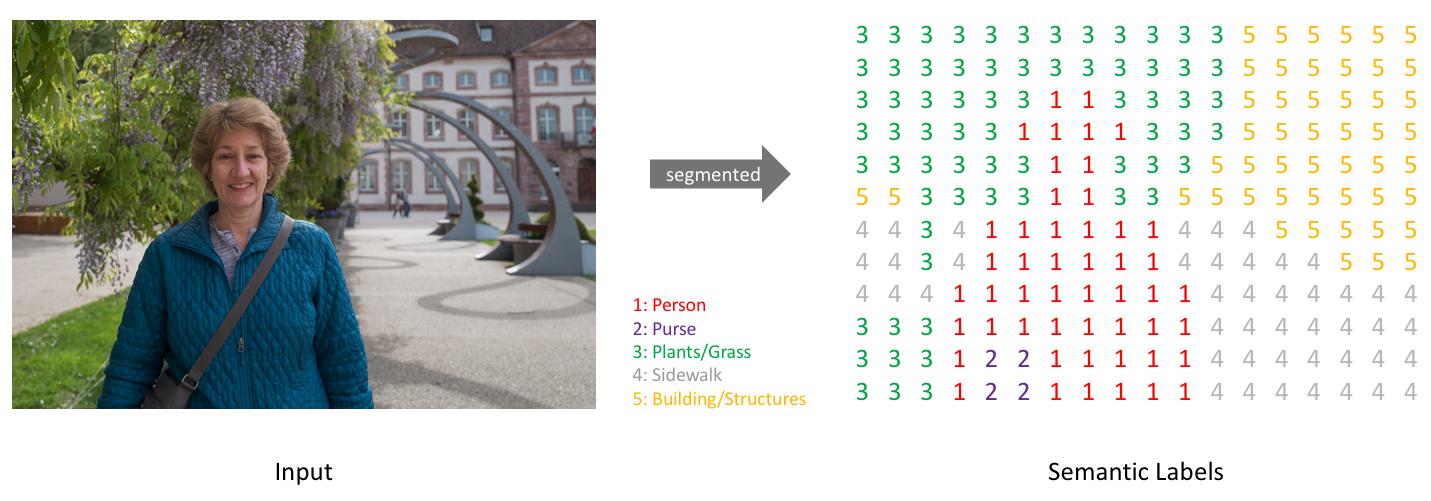

In [ ]:
'''
for each image change the rgb color with the respective class index
'''
def color_to_class(x, label):
  for cls, col in class_rgb.items(): 
    mask = tf.reduce_all(label == col, axis=3)
    mask = tf.reshape(mask, (BATCH_SIZE, 720, 960, 1))
    new_label = tf.where(mask, tf.constant(cls, dtype=tf.uint8), label)
    label = new_label
  return (x, label[:,:,:,0:1])


  '''
  Transforms the pixels from the class idx to the relative
  RGB color.
  '''
def from_class_to_rgb(pred, is_pred = True):

  if is_pred:
    pred = tf.argmax(pred, axis=3)
    pred = tf.reshape(pred, (16,128,128,1))
  pred = tf.cast(pred, tf.uint8)

  for cls, col in class_rgb.items(): 
    mask = tf.reduce_all(pred == cls, axis=3)
    mask = tf.reshape(mask, (BATCH_SIZE, 128, 128, 1))
    new_pred = tf.where(mask, tf.constant(col, dtype=tf.uint8), pred)
    pred = new_pred
  return pred

**DATA PRE-PROCESSING**

In [ ]:
'''resize the image since the hardware is limited and can’t process to much large images'''
def img_processing(x, label):
  x = tf.image.resize(x , (196, 196))
  label = tf.image.resize(label , (196, 196))
  x,label = custom_crop(x, label, 128, 128)
  return (x, label)

'''
for each batch randomly generate the top left pixel of the cropped image and use it for both data and label
'''
def custom_crop(x, label , cropped_height, cropped_width):

  original_width = 196
  original_height = 196

  top_left_corner_x = tf.random.uniform(minval=0, maxval=original_width - cropped_width -1 , 
                                      shape=(1,), dtype=tf.int32)
  top_left_corner_y = tf.random.uniform(minval=0, maxval=original_height - cropped_height- 1, 
                                      shape=(1,), dtype=tf.int32)
  
  x = tf.image.crop_to_bounding_box(x, top_left_corner_y[0], 
                                    top_left_corner_x[0], 
                                    cropped_height, cropped_width)
  
  label = tf.image.crop_to_bounding_box(label, top_left_corner_y[0], 
                                    top_left_corner_x[0], 
                                    cropped_height, cropped_width)
  return (x, label)

In [68]:
'''Create datasets whose elements are slices of the given tensors.
   Creation of the input pipeline'''
BATCH_SIZE = 16 #set Batch size

train_set = tf.data.Dataset.from_tensor_slices((train_paths, train_label_paths))
train_set = train_set.map(lambda x,y: load_images(x,y,'train')).shuffle(1000).batch(BATCH_SIZE, drop_remainder=True).map(color_to_class).map(img_processing)
train_set = train_set.cache().prefetch(tf.data.AUTOTUNE)

val_set = tf.data.Dataset.from_tensor_slices((val_paths, val_label_paths))
val_set = val_set.map(lambda x,y: load_images(x,y,'val')).shuffle(1000).batch(BATCH_SIZE, drop_remainder=True).map(color_to_class).map(img_processing)
val_set = val_set.cache().prefetch(tf.data.AUTOTUNE)

test_set = tf.data.Dataset.from_tensor_slices((test_paths,test_label_paths))
test_set = test_set.map(lambda x,y: load_images(x,y,'test')).shuffle(1000).batch(BATCH_SIZE, drop_remainder=True).map(color_to_class).map(img_processing)


A original image and label are shown as an example in belove

In [ ]:
x,y = next(iter(train_set))

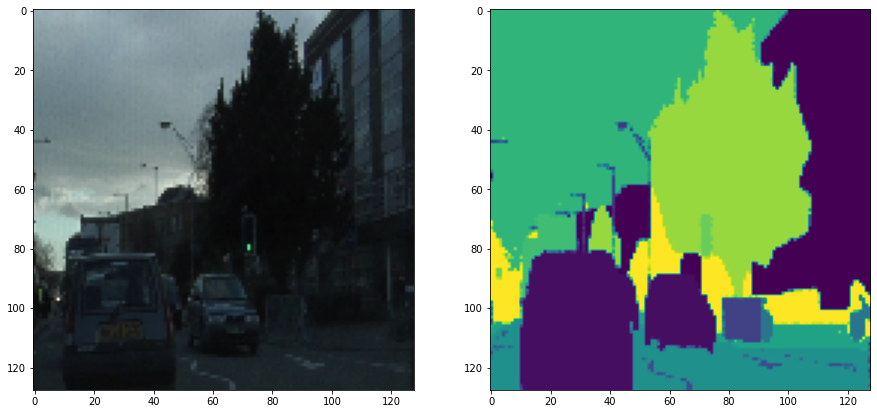

In [ ]:
plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
plt.imshow(x[5])
plt.subplot(1,2,2)
plt.imshow(y[5,:,:,0])

**BUILDING MODEL**

Given an input image, the goal of a segmentation method is to predict a segmentation mask that highlights an object (or objects) of interest.
For this, the UNET is used which is one of the widely used architectures used for segmentation.

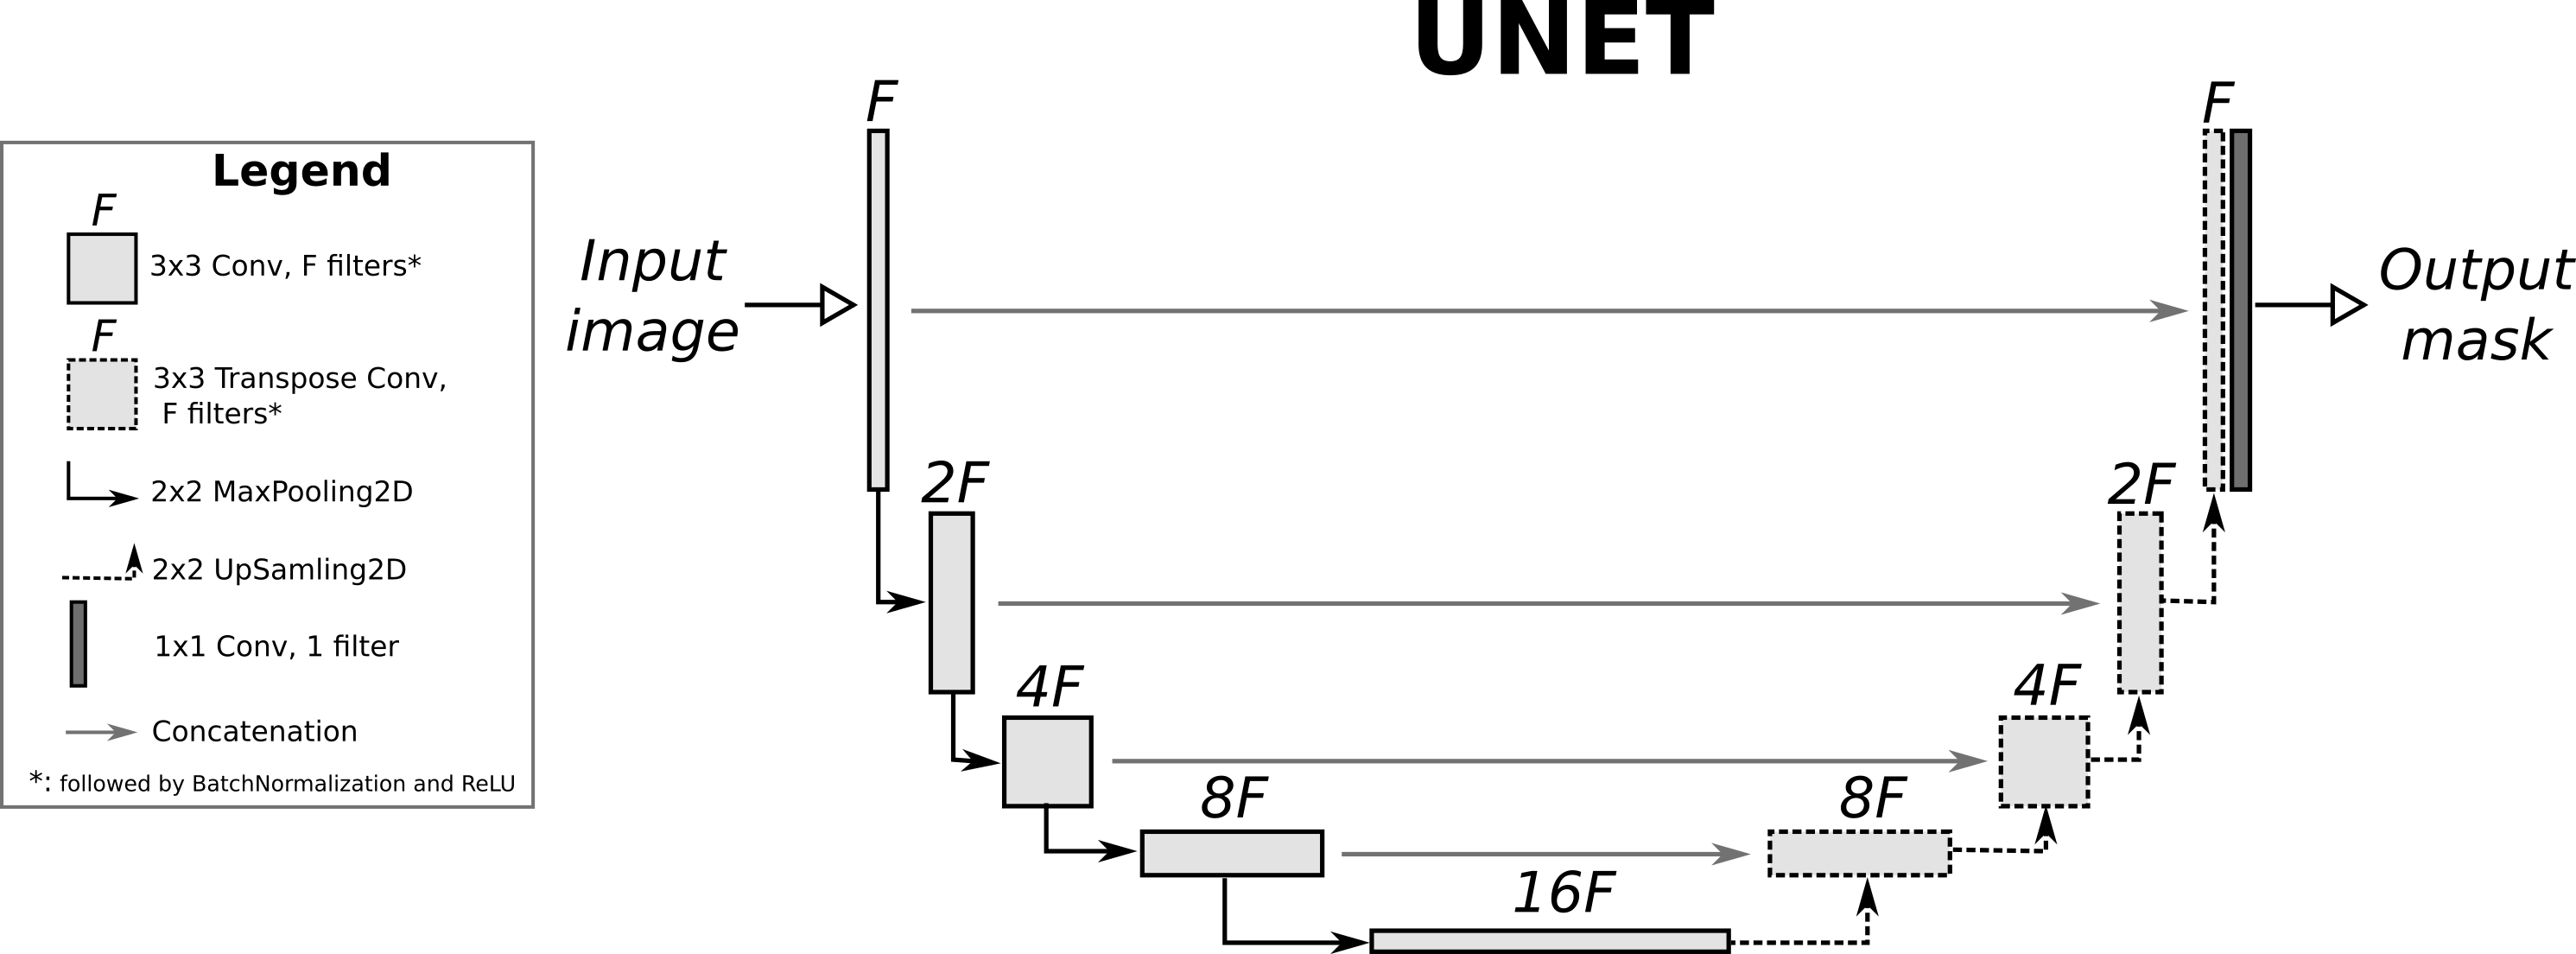

In [ ]:
'''
- Create 2D convolution layer
- Same padding results in padding evenly to the left/right or up/down of the input such that output has the same height/width dimension as the input.
- ???????he_normal It draws samples from a truncated normal distribution centered on 0 with stddev = sqrt(2 / fan_in) where fan_in is the number of input units in the weight tensor.
- ReLU activation: max(x, 0), the element-wise maximum of 0 and the input tensor.
'''
def conv(filters,filter_size, inputs):
  conv = Conv2D(filters, filter_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
  conv = Conv2D(filters, filter_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv)
  return conv
'''
Upsampling layer for 2D inputs
'''
def up(filters,filter_size,inputs):
  return  Conv2D(filters,filter_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(inputs))

In [ ]:
'''
- Call conv function to create 2D convolution layers

- Max pooling operation downsamples the input representation by taking the maximum value over the window defined 
by pool_size for each dimension along the features axis. The window is shifted by strides in each dimension.

- The Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time,
 which helps prevent overfitting. Inputs not set to 0 are scaled up by 1/(1 - rate) such that the sum over all inputs is unchanged.

- Concatenate is functional interface to the Concatenate layer.

- Softmax converts a real vector to a vector of categorical probabilities. The elements of the output vector are in range (0, 1) and sum to 1.
The softmax of each vector x is computed as exp(x) / tf.reduce_sum(exp(x)).

- SparseCategoricalCrossentropy computes the crossentropy loss between the labels and predictions.
'''
def m_unet(number_of_classes, input_size = (128,128,3)):
    inputs = Input(input_size)
    # Block 1
    conv1=conv(64,3, inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    # Block 2
    conv2 = conv(128,3, pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    # Block 3
    conv3 = conv(256,3, pool2)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    # Block 4
    conv4 = conv(512,3, pool3)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
    
    # Block 5
    conv5 = conv(1024,3, pool4)
    drop5 = Dropout(0.5)(conv5)
    
    # Block 6
    up6=up(512,2,drop5)
    merge6= concatenate([drop4,up6],axis=3)
    conv6 = conv(512,3,merge6)
    
    #Block 7
    up7=up(256,2,conv6)
    merge7= concatenate([conv3,up7],axis=3)
    conv7 = conv(256,3, merge7)
    
    #Block 8
    up8=up(128,2,conv7)
    merge8= concatenate([conv2,up8],axis=3)
    conv8 = conv(128,3, merge8)
    
    #Block 9
    up9=up(64,2,conv8)
    merge9= concatenate([conv1,up9],axis=3)
    conv9 = conv(64,3, merge9)
      
    output_layer = Conv2D(number_of_classes, (1,1), padding='same')(conv9) #Create a convolution layer to combine the dimensions of the input feature maps down to the number of classes.
    output_layer = Activation('softmax')(output_layer)
     

    model = Model( inputs,output_layer)
    model.compile(optimizer = Adam(lr = 1e-4), loss = tf.keras.losses.SparseCategoricalCrossentropy(), metrics = ['accuracy'])
    return model

In [ ]:
model = m_unet(32)
model.summary()

**TRAINING AND TESTING THE MODEL**

In [70]:
'''
Added two callbacks, one to stop training if an early stopping condition is met,
 the other to stop training if some NaN values are encountered in the loss.
'''
all_callbacks = [
             callbacks.EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True),
             callbacks.TerminateOnNaN(),
              callbacks.History()
            ]

In [79]:
'''Train the model'''
history = model.fit(train_set, epochs=20, validation_data=val_set, callbacks=all_callbacks)

Epoch 1/20
26/26 [==============================] - 8s 288ms/step - loss: 0.7053 - accuracy: 0.8150 - val_loss: 0.9235 - val_accuracy: 0.7600
Epoch 2/20
26/26 [==============================] - 8s 291ms/step - loss: 0.7004 - accuracy: 0.8160 - val_loss: 0.8893 - val_accuracy: 0.7697
Epoch 3/20
26/26 [==============================] - 8s 297ms/step - loss: 0.6816 - accuracy: 0.8201 - val_loss: 0.9239 - val_accuracy: 0.7579
Epoch 4/20
26/26 [==============================] - 8s 302ms/step - loss: 0.6736 - accuracy: 0.8219 - val_loss: 0.8731 - val_accuracy: 0.7749
Epoch 5/20
26/26 [==============================] - 8s 304ms/step - loss: 0.6758 - accuracy: 0.8216 - val_loss: 0.8636 - val_accuracy: 0.7774
Epoch 6/20
26/26 [==============================] - 8s 299ms/step - loss: 0.6620 - accuracy: 0.8260 - val_loss: 0.8278 - val_accuracy: 0.7879
Epoch 7/20
26/26 [==============================] - 8s 294ms/step - loss: 0.6321 - accuracy: 0.8345 - val_loss: 0.8700 - val_accuracy: 0.7772
Epoch 

In [91]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

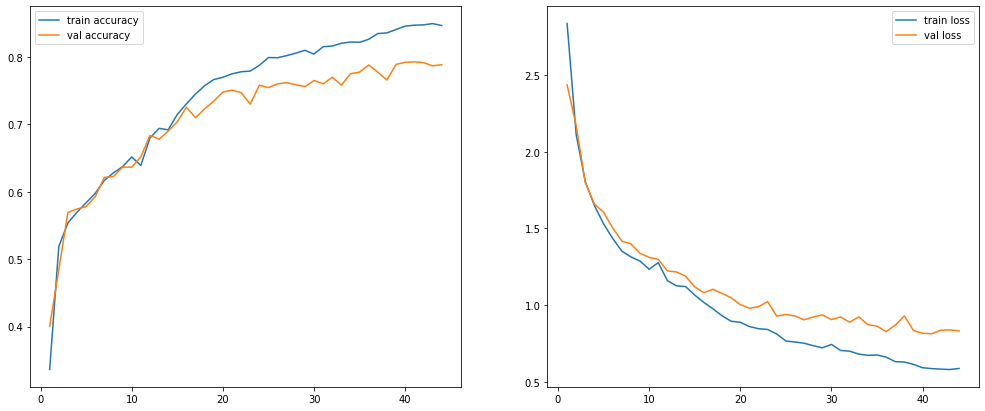

In [95]:
'''
plot graph to show train and loss details
'''
epochs = np.arange(1, len(history.history['accuracy'])+1,1)
plt.figure(figsize=(17,7))
plt.subplot(1,2,1)
plt.plot(epochs,  history.history['accuracy'] ,label='train accuracy')
plt.plot(epochs,  history.history['val_accuracy'] ,label='val accuracy')
plt.legend()
plt.subplot(1,2,2)
plt.plot(epochs,  history.history['loss'] ,label='train loss')
plt.plot(epochs,  history.history['val_loss'] ,label='val loss')
plt.legend()

In [81]:
'''Save the weights'''
path = '/content/drive/MyDrive/Cartella senza titolo'
model.save_weights(path)

In [82]:
'''Test the model'''
model.evaluate(test_set)

10/10 [==============================] - 93s 9s/step - loss: 0.7864 - accuracy: 0.8004


[0.7863581776618958, 0.8003559112548828]

**Evaluate the Quality of the Prediction**

The Intersection-Over-Union (IoU, Jaccard Index) and Dice Coefficient (F1 Score) are one of the most commonly used metrics in semantic segmentation.

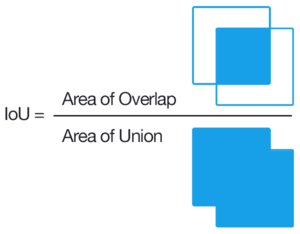





The IoU (Jaccard Index) is the area of overlap between the predicted segmentation and the ground truth divided by the area of union between the predicted segmentation and the ground truth. 
This metric ranges from 0–1 (0–100%) with 0 signifying no overlap and 1 signifying perfectly overlapping segmentation

In [96]:

def iou_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  return iou

The Dice coefficient is very similar to the IoU. They are positively correlated, meaning if one says model A is better than model B at segmenting an image, then the other will say the same.
Like the IoU, they both range from 0 to 1, with 1 signifying the greatest similarity between predicted and truth

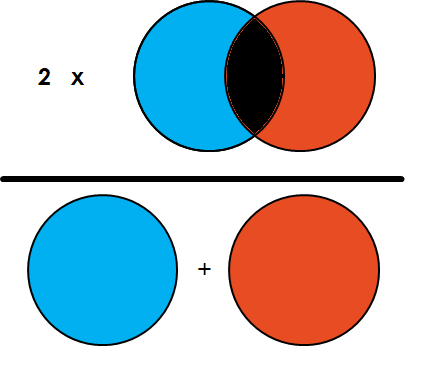

In [97]:
def dice_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(y_true * y_pred, axis=[1,2,3])
  union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
  dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
  return dice

In [98]:
all_jaccards = []
all_dice = []
for x,y in test_set:
  pred = model(x)

  try:
    true_target = tf.reshape(y, (BATCH_SIZE, 128, 128,1))
    true_target = tf.keras.utils.to_categorical(true_target, num_classes=32)
 
    all_jaccards.append(iou_coef(true_target, pred))
    all_dice.append(dice_coef(true_target, pred))
  except:
    pass

Results of Iou coefficient (Jaccard Index) and Dice coefficient:

In [99]:
tf.reduce_mean(all_jaccards), tf.reduce_mean(all_dice)

(<tf.Tensor: shape=(), dtype=float32, numpy=0.5564134>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.71042186>)

**Examples of Predictions**

In [100]:
x, label = next(iter(test_set))
pred = model(x)
pred = from_class_to_rgb(pred)
label = from_class_to_rgb(label, is_pred=False)

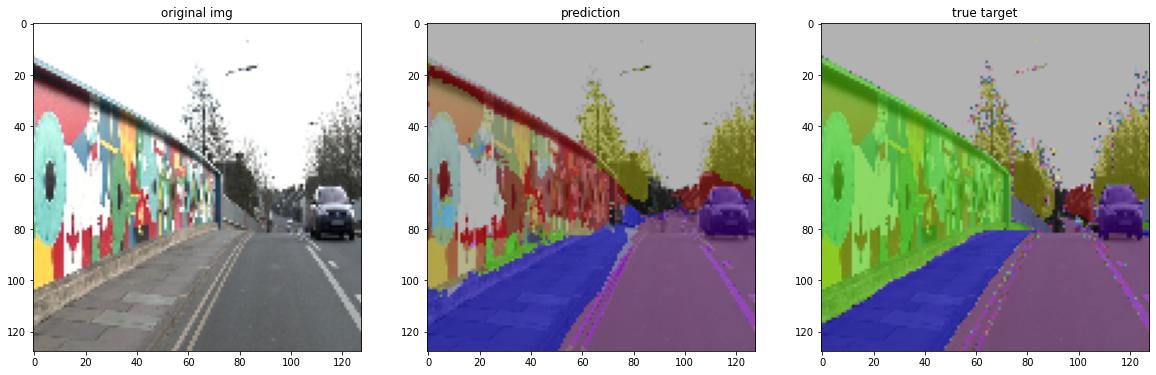

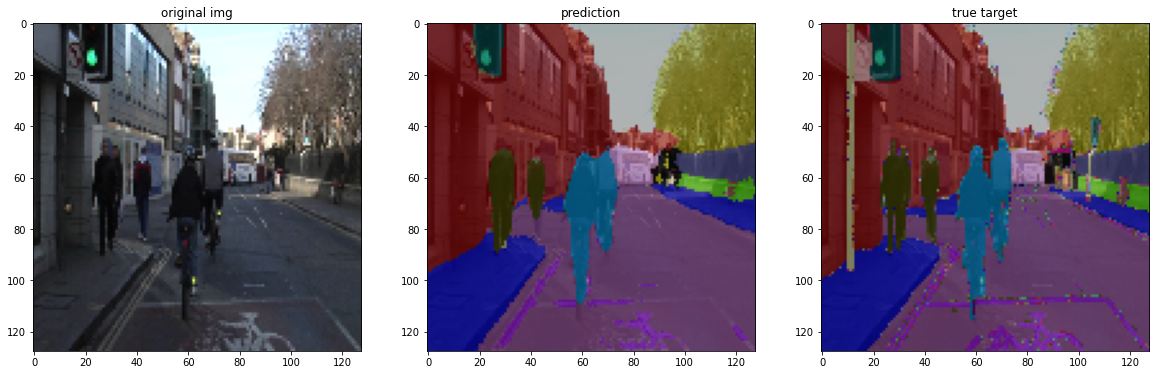

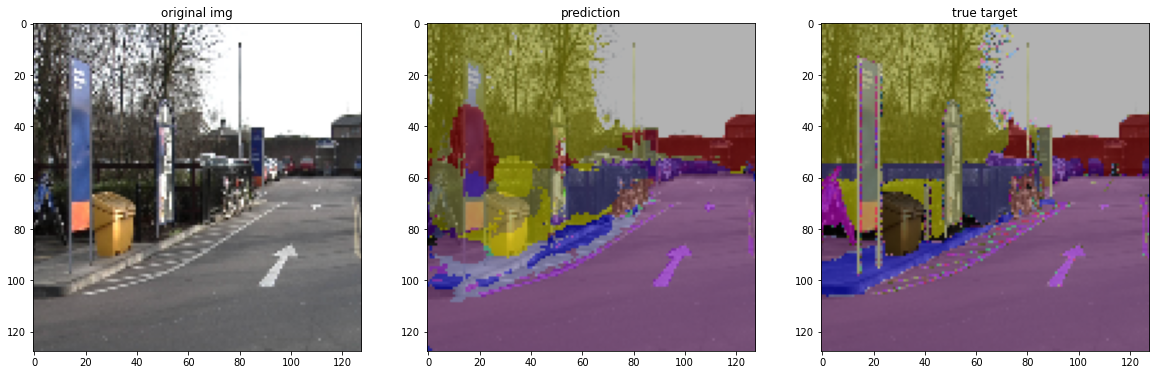

In [101]:
for i in [1,4,7]:
  plt.figure(figsize=(20,30))
  plt.subplot(3,3,i)
  plt.title('original img')
  plt.imshow(x[i])
  plt.subplot(3,3,i+1)
  plt.title('prediction')
  plt.imshow(x[i])
  plt.imshow(pred[i], alpha=0.6)
  plt.subplot(3,3,i+2)
  plt.title('true target')
  plt.imshow(x[i])
  plt.imshow(label[i], alpha=0.6)